# Table of Contents
- [Introduction](#introduction-nfl-combine)
- [The Data](#data)
- [Exploratory Data Analysis](#eda)
    - [Investigating Nulls](#nulls)
    - [Data Cleaning](#cleaning)
    - [Feature Engineering](#fe)
- [Modeling](#model)
    - [K-Nearest Neighbors](#knn)
    - [Logistic Regression](#lr)
    - [Random Forest](#rf)
- [Conclusion](#end)
    - [Findings](#find)
    - [Next Steps](#next)
- [Appendex](#app)

<a id="intro"></a>
# Introduction: NFL Combine

**The NFL Combine** is a week of events for potential NFL players to show coaches, general managers and scouts their abilities. Teams use the combine results to inform their draft selections.   

In the past 17 years, 64% of combine participats have gotten drafted. Can draft results be predicited based on combine performance? 

In [87]:
#import packages 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import re
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics, datasets 
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model, model_selection, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
%matplotlib inline

<a id="data"></a>
# Combine Data

This [Kaggle data](https://www.kaggle.com/kbanta11/nfl-combine) provides the last 17 years of combine results, and draft results (if applicable). There are 34 different file (each year has two CSVs: offense and defense). 

In [88]:
path = './data/'
files = glob.glob(path+"/*.csv")
nfl = pd.DataFrame()
lst= []
#append files together to make a single DataFrame
for file_ in files:
    df = pd.read_csv(file_,index_col=None, header=0)
    lst.append(df)
nfl = pd.concat(lst)

nfl.head()

,Rk,Year,Player,Pos,AV,School,College,Height,Wt,40YD,Vertical,BenchReps,Broad Jump,3Cone,Shuttle,Drafted (tm/rnd/yr)
0,1,2000,Brian Young\YounBr20,DE,47.0,Texas-El Paso,College Stats,6-2,278,4.94,29.5,27.0,106.0,7.20,4.47,St. Louis Rams / 5th / 139th pick / 2000
1,2,2000,Cedric Woodard\WoodCe20,DT,15.0,Texas,NaN,6-2,290,5.21,30.5,23.0,109.0,NaN,NaN,Baltimore Ravens / 6th / 191st pick / 2000
2,3,2000,Antonio Wilson\WilsAn20,OLB,2.0,Texas A&M-Commerce,NaN,6-2,245,4.56,NaN,11.0,NaN,NaN,NaN,Minnesota Vikings / 4th / 106th pick / 2000
3,4,2000,Josh Williams\WillJo30,DT,19.0,Michigan,NaN,6-3,282,4.90,30.5,NaN,111.0,7.22,4.25,Indianapolis Colts / 4th / 122nd pick / 2000
4,5,2000,Damen Wheeler\WheeDa20,CB,0.0,Colorado,NaN,5-9,179,4.51,35.0,11.0,115.0,7.21,4.27,San Diego Chargers / 6th / 203rd pick / 2000


<a id="eda"></a>
# Exploratory Data Analysis

The DataFrame has 16 columns ('Rk', 'Year', 'Player', 'Pos', 'AV', 'School', 'College', 'Height', 'Wt', '40YD', 'Vertical', 'BenchReps', 'Broad Jump', '3Cone', 'Shuttle','Drafted (tm/rnd/yr)') and 5636 rows

In [89]:
print('SHAPE:\n',nfl.shape)
print('\n')
print('COLUMNS:\n',nfl.columns)
print('\n')

SHAPE:
 (5636, 16)


COLUMNS:
 Index(['Rk', 'Year', 'Player', 'Pos', 'AV', 'School', 'College', 'Height',
       'Wt', '40YD', 'Vertical', 'BenchReps', 'Broad Jump', '3Cone', 'Shuttle',
       'Drafted (tm/rnd/yr)'],
      dtype='object')




**The info shows that there are multiple data types, as well as many nulls** 

In [90]:
print('info\n',nfl.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5636 entries, 0 to 166
Data columns (total 16 columns):
Rk                     5636 non-null int64
Year                   5636 non-null int64
Player                 5636 non-null object
Pos                    5636 non-null object
AV                     4089 non-null float64
School                 5636 non-null object
College                4402 non-null object
Height                 5636 non-null object
Wt                     5636 non-null int64
40YD                   5553 non-null float64
Vertical               4413 non-null float64
BenchReps              3828 non-null float64
Broad Jump             4374 non-null float64
3Cone                  3686 non-null float64
Shuttle                3742 non-null float64
Drafted (tm/rnd/yr)    3617 non-null object
dtypes: float64(7), int64(3), object(6)
memory usage: 748.5+ KB
info
 None


**Describe shows statistics around the numeric columns, including object shows non-numeric columns**

In [91]:
print('DESCRIBE:\n',nfl.describe())
print('\n')
print('DESCRIBE + OBJECT:\n',nfl.describe(include=['object']))

DESCRIBE:
                 Rk         Year           AV           Wt         40YD  \
count  5636.000000  5636.000000  4089.000000  5636.000000  5553.000000   
mean     78.977999  2008.529631    16.823918   242.491306     4.770501   
std      45.539166     5.180094    23.971114    44.600760     0.300133   
min       1.000000  2000.000000    -4.000000   149.000000     4.220000   
25%      40.000000  2004.000000     1.000000   206.000000     4.540000   
50%      79.000000  2009.000000     7.000000   233.000000     4.690000   
75%     118.000000  2013.000000    23.000000   273.000000     4.950000   
max     172.000000  2017.000000   255.000000   375.000000     6.050000   

          Vertical    BenchReps   Broad Jump        3Cone      Shuttle  
count  4413.000000  3828.000000  4374.000000  3686.000000  3742.000000  
mean     32.966010    20.840909   114.210791     7.270757     4.381168  
std       4.163298     6.347158     9.146190     0.419310     0.268175  
min      17.500000     2.00000

**Wide recievers are the most common position, because of the variation in skills needed for the different positions, I will foucs on the WR position**

In [92]:
nfl.Pos.value_counts()

WR     813
CB     589
RB     509
DE     471
DT     439
OT     437
OLB    411
OG     365
QB     331
TE     320
ILB    261
FS     229
SS     213
FB     116
P      113
LS      19
Name: Pos, dtype: int64

**"nflwr" will be "nfl" filtered to only wide recievers**

In [93]:
nflwr = nfl.loc[nfl['Pos']== 'WR']

In [94]:
print('SHAPE:\n',nflwr.shape)
print('\n')
print('COLUMNS:\n',nflwr.columns)
print('\n')
print('info\n',nflwr.info())
print('\n')
print('DESCRIBE:\n',nflwr.describe())
print('\n')
print('DESCRIBE + OBJECT:\n',nflwr.describe(include=['object']))

SHAPE:
 (813, 16)


COLUMNS:
 Index(['Rk', 'Year', 'Player', 'Pos', 'AV', 'School', 'College', 'Height',
       'Wt', '40YD', 'Vertical', 'BenchReps', 'Broad Jump', '3Cone', 'Shuttle',
       'Drafted (tm/rnd/yr)'],
      dtype='object')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 813 entries, 0 to 157
Data columns (total 16 columns):
Rk                     813 non-null int64
Year                   813 non-null int64
Player                 813 non-null object
Pos                    813 non-null object
AV                     559 non-null float64
School                 813 non-null object
College                706 non-null object
Height                 813 non-null object
Wt                     813 non-null int64
40YD                   805 non-null float64
Vertical               653 non-null float64
BenchReps              359 non-null float64
Broad Jump             636 non-null float64
3Cone                  527 non-null float64
Shuttle                540 non-null float64
Drafte

<a id="nulls"></a>
## Investigating Nulls

Many players do not do all of the events:  
-	40YD: 1% nulls 
-	Vertical: 22% nulls 
-	Bench Reps: 32% nulls 
-	Broad Jump: 22% nulls 
-	3 Cone: 35% nulls 
-	Shuttle: 34% nulls

Results are similar when looking at WR only:
-	40YD: 1% nulls
-	Vertical: 20% nulls
-	Bench Reps: 56% nulls
-	Broad Jump: 22% nulls
-	3 Cone: 35% nulls
-	Shuttle: 34% nulls

NFL DataFrame NULLS 

Rk                        0
Year                      0
Player                    0
Pos                       0
AV                     1547
School                    0
College                1234
Height                    0
Wt                        0
40YD                     83
Vertical               1223
BenchReps              1808
Broad Jump             1262
3Cone                  1950
Shuttle                1894
Drafted (tm/rnd/yr)    2019
dtype: int64


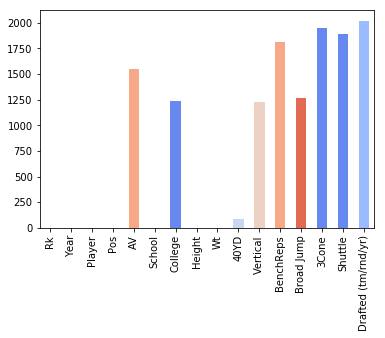

In [95]:
print('NFL DataFrame NULLS \n')
print(nfl.isnull().sum());
nfl.isnull().sum().plot(kind='bar');

NFLWR DataFrame NULLS 

Rk                       0
Year                     0
Player                   0
Pos                      0
AV                     254
School                   0
College                107
Height                   0
Wt                       0
40YD                     8
Vertical               160
BenchReps              454
Broad Jump             177
3Cone                  286
Shuttle                273
Drafted (tm/rnd/yr)    322
dtype: int64


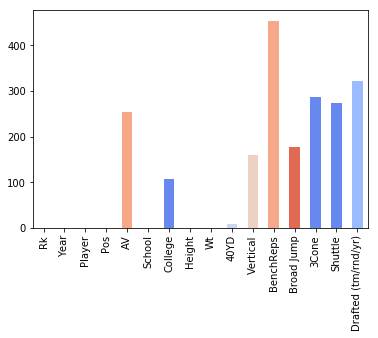

In [96]:
print('NFLWR DataFrame NULLS \n')
print(nflwr.isnull().sum());
nflwr.isnull().sum().plot(kind='bar');

**To address the nulls, I will replace them with '-1'. Replacing them with '0' would skew the speed metrics, as running the 40 yard dash in 0 seconds would be desirable. There are too many player with nulled events to drop the whole row**

In [97]:
nfl['40YD'].fillna(-1, inplace=True)
nfl['Vertical'].fillna(-1, inplace=True)
nfl['BenchReps'].fillna(-1, inplace=True)
nfl['Broad Jump'].fillna(-1, inplace=True)
nfl['3Cone'].fillna(-1, inplace=True)
nfl['Shuttle'].fillna(-1, inplace=True)

<a id="cleaning"></a>
## Cleaning the Data

Some of the columns need to be cleaned to be usable: 
- Break Drafted (tm/rnd/yr) in to 'Round' & 'Pick'
- Convert height from feet to inches 
- Drop unneeded columns
- Change datatypes accordingly

After feature engineering, apply all changes to nfl DataFrame, reassign nflwr to the new nfl filtered to just WR

In [98]:
#nfl['Team']= nfl['Drafted (tm/rnd/yr)'].str.split(' / ', expand=True)[0]
#nfl['Player']=nfl['Player'].str.split('\\',expand=True)[0]
nfl['Round']= nfl['Drafted (tm/rnd/yr)'].str.split(' / ', expand=True)[1].str.extract('([0-9]+)',expand=True)
nfl['Pick']= nfl['Drafted (tm/rnd/yr)'].str.split(' / ', expand=True)[2].str.extract('([0-9]+)',expand=True)
nfl['Height'] = (nfl['Height'].str.split('-',expand=True)[0].astype(int)*12) + nfl['Height'].str.split('-',expand=True)[1].astype(int)
nfl['Round'].fillna(0, inplace=True) # Undrafted = 0
nfl['Pick'].fillna(0, inplace=True) # Undrafted = 0

In [99]:
nfl = nfl.drop(['Drafted (tm/rnd/yr)'], axis=1)
nfl = nfl.drop(['School'], axis=1)
nfl = nfl.drop(['College'], axis=1)
nfl = nfl.drop(['AV'], axis=1)
nfl = nfl.drop(['Rk'], axis=1)
nfl = nfl.drop(['Year'], axis=1)
nfl = nfl.drop(['Player'], axis=1)

In [100]:
nfl['Round']= nfl['Round'].astype(np.int64)
nfl['Pick']= nfl['Pick'].astype(np.int64)

**There are 7 rounds in the NFL draft, Round = 0 for an undrafted player**

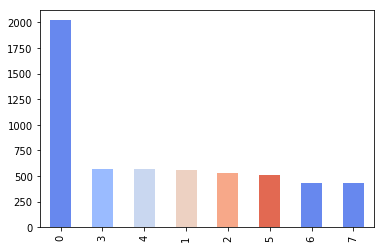

In [101]:
nfl.Round.value_counts().plot(kind='bar')  

<a id="fe"></a>
## Feature Engineering

Some of the events can be grouped by tested skills, these groupings give another modeling option: 
- Speed events: 40 Yard Dash + 3 Cone + Shuttle 
- Jump events  Vertical + Broad Jump 

Height and weight can also be consolidated in to BMI via the [CDC's BMI Formula](https://www.cdc.gov/healthyweight/assessing/bmi/childrens_bmi/childrens_bmi_formula.html)

Being in the first round is desirable for a player, 'first' will be a flag where 1 = first round draft pick, 0 = not first round (including undrafted)

In [102]:
nfl['speed_trial'] = nfl['40YD']+nfl['3Cone']+nfl['Shuttle']
nfl['jump_trial'] = nfl['Vertical']+nfl['Broad Jump']
nfl['bmi'] = (703*nfl['Wt'].astype(float))/(nfl['Height'].astype(float)**2)
nfl['first'] = nfl.Round.map({0:0, 1:1, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}) # flag for a first round draft pick

**Apply data cleaning and feature engineering to WR DataFrame. This is the DataFrame I will use for modeling**

In [103]:
nflwr = nfl.loc[nfl['Pos']== 'WR'];
nflwr.head()

,Pos,Height,Wt,40YD,Vertical,BenchReps,Broad Jump,3Cone,Shuttle,Round,Pick,speed_trial,jump_trial,bmi,first
0,WR,75,191,4.53,33.0,-1.0,130.0,7.09,4.18,0,0,15.80,163.0,23.870756,0
2,WR,71,180,4.59,36.0,-1.0,123.0,7.22,4.16,6,175,15.97,159.0,25.102162,0
5,WR,73,218,4.62,37.5,-1.0,124.0,6.91,4.09,3,69,15.62,161.5,28.758491,0
8,WR,71,194,4.58,-1.0,-1.0,-1.0,-1.00,-1.00,1,4,2.58,-2.0,27.054553,1
9,WR,66,171,4.55,32.5,-1.0,106.0,6.61,3.84,5,165,15.00,138.5,27.597107,0


<a id="model"></a>
# Modeling

first         -0.168586
Height        -0.088930
Wt            -0.053137
40YD          -0.019241
Shuttle        0.017224
speed_trial    0.020217
3Cone          0.024380
bmi            0.026312
Broad Jump     0.038217
BenchReps      0.041080
jump_trial     0.048434
Vertical       0.078002
Pick           0.988955
Round          1.000000
Name: Round, dtype: float64

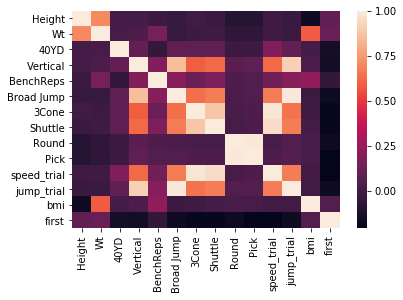

In [74]:
#Visual Correlation
sns.set_palette('coolwarm')
sns.heatmap(nflwr.corr())
nflwr.corr().Round.sort_values()

<a id="knn"></a>
## K- Nearest Neighbors

In [75]:
#matrix (X), response (y)
feature_cols = ['Height', 'Wt', '40YD', 'Vertical', 'BenchReps','Broad Jump','3Cone','Shuttle']
X = nflwr[feature_cols]
y = nflwr.Round

In [76]:
#break out test and train 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

In [77]:
#try 1 neighbor 
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [78]:
y_pred_class = knn.predict(X_test)
print('Accuracy Score for 1 Neighbor:',(metrics.accuracy_score(y_test, y_pred_class)))

Accuracy Score for 1 Neighbor: 0.27450980392156865


In [79]:
# Best number of neighbors 
k_range = list(range(1, 609))
training_error = []
testing_error = []

# Find test accuracy for all values of K
for k in k_range:

    # model with the current K value.
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # training error = (error = 1 - accuracy)
    y_pred_class = knn.predict(X)
    training_accuracy = metrics.accuracy_score(y, y_pred_class)
    training_error.append(1 - training_accuracy)
    
    # testing error
    y_pred_class = knn.predict(X_test)
    testing_accuracy = metrics.accuracy_score(y_test, y_pred_class)
    testing_error.append(1 - testing_accuracy)

In [80]:
column_dict = {'K': k_range, 'training error':training_error, 'testing error':testing_error}
df = pd.DataFrame(column_dict).set_index('K').sort_index(ascending=False)
df.head()

,training error,testing error
K,,
608,0.603936,0.593137
607,0.603936,0.593137
606,0.603936,0.593137
605,0.603936,0.593137
604,0.603936,0.593137


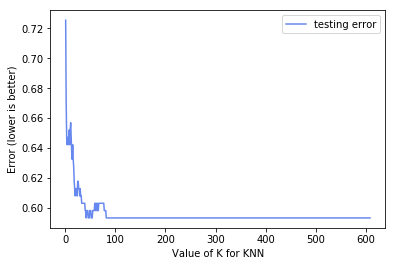

In [81]:
df.plot(y='testing error');
plt.xlabel('Value of K for KNN');
plt.ylabel('Error (lower is better)');

In [82]:
df.sort_values('testing error').head()

,training error,testing error
K,,
608,0.603936,0.593137
243,0.603936,0.593137
244,0.603936,0.593137
245,0.603936,0.593137
246,0.603936,0.593137


In [83]:
knn = KNeighborsClassifier(n_neighbors=143)
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class)))

0.4068627450980392


We do not get optimal result because accuracy scores do not work well for imbalanced data 

<a id="lr"></a>
## Logistic Model: First Round or not

Using logistic regression to look at probability a player will go in the first round

In [104]:
# 71 WRs have gone in the first round
nflwr.Round.value_counts().sort_index()

0    322
1     71
2     77
3     83
4     76
5     61
6     64
7     59
Name: Round, dtype: int64

In [106]:
lr = LogisticRegression()
X = nflwr[['Height','Wt','40YD','Vertical','BenchReps','Broad Jump','3Cone','Shuttle']]
y = nflwr['first']

lr.fit(X,y)
pred = lr.predict(X)

X_train, X_test, y_train, y_test = train_test_split(X,y)

lr.fit(X_train,y_train)

y_pred = lr.predict_proba(X_test)
#because this is an imbalance class problem, predict_proba is better than predict
lr.score(X_test, y_test)


0.946078431372549

In [1]:
#confusion matrix 
logit_simple = linear_model.LogisticRegression(C=1e9).fit(X_train, y_train)
logit_pred_proba = logit_simple.predict_proba(X_test)[:,1]
a = metrics.confusion_matrix(y_true=y_test, y_pred=logit_pred_proba > .25)
print(a)


NameError: name 'linear_model' is not defined

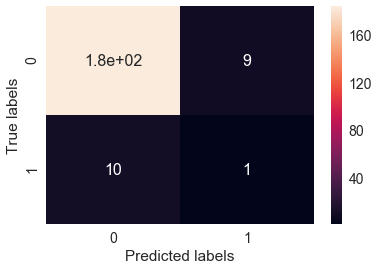

In [128]:
ax= plt.subplot()
#plt.figure(figsize = (10,7))
#sns.set(font_scale=1.4)#for label size
sns.heatmap(a, annot=True,annot_kws={"size": 16})# font size
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 

In [129]:
#let's see how well our engineered features perform
X = nflwr[['speed_trial','jump_trial','bmi']]
y = nflwr['first']

lr.fit(X,y)
pred = lr.predict(X)

X_train, X_test, y_train, y_test = train_test_split(X,y)

lr.fit(X_train,y_train)

y_pred = lr.predict_proba(X_test)
#because this is an imbalance class problem, predict_proba is better than predict
lr.score(X_test, y_test)

0.9117647058823529

In [133]:
#confusion matrix 
logit_simple = linear_model.LogisticRegression(C=1e9).fit(X_train, y_train)
logit_pred_proba = logit_simple.predict_proba(X_test)[:,1]
metrics.confusion_matrix(y_true=y_test, y_pred=logit_pred_proba > .5)

array([[186,   0],
       [ 18,   0]])

In [131]:
df_cm = pd.DataFrame(array, range(6),
                  range(6))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

NameError: name 'array' is not defined

<a id="rf"></a>
## Random Forest

Random Forest explination 
ROC = Receiver operating characteristic

AUC means Area Under Curve ; you can calculate the area under various curves though. Common is the ROC curve which is about the tradeoff between true positives and false positives at different thresholds. This AUC value can be used as an evaluation metric, especially when there is imbalanced classes.

In [40]:
X = nflwr[['Height','Wt','40YD','Vertical','BenchReps','Broad Jump','3Cone','Shuttle']]
y = nflwr['Round']
y = label_binarize(y, classes=[0,1,2,3,4,5,6,7])
#turn y in to an array, boolean for each round 
n_classes = y.shape[1]

In [41]:
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# classifier
clf=RandomForestClassifier(random_state=0)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [42]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# ROC AUC is better for looking at multiclass 

Accuracy: 0.1598360655737705


In [45]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

Draft Round: 0


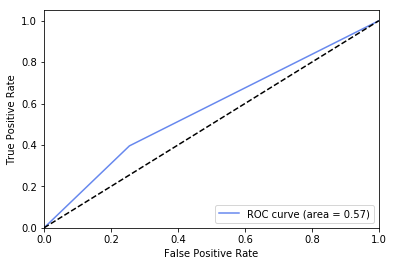

Draft Round: 1


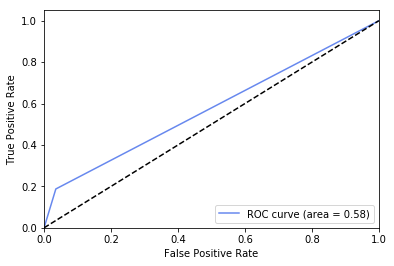

Draft Round: 2


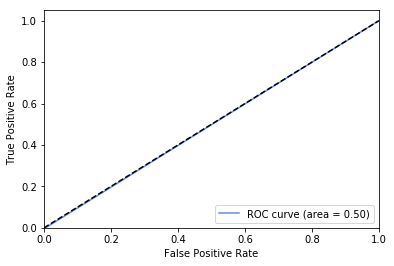

Draft Round: 3


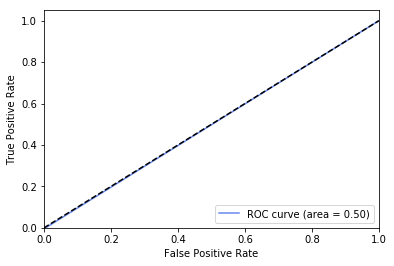

Draft Round: 4


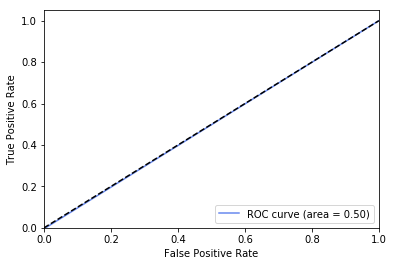

Draft Round: 5


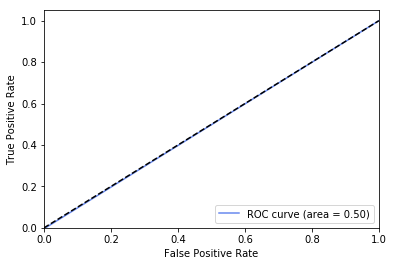

Draft Round: 6


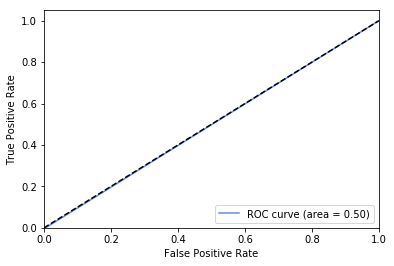

Draft Round: 7


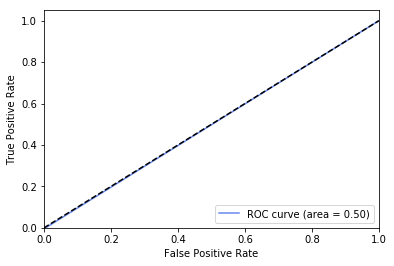

In [46]:
for i in range(n_classes):
    print('Draft Round:',i)
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [47]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

40YD          0.216853
Wt            0.160880
3Cone         0.113625
Height        0.108240
Broad Jump    0.105818
Shuttle       0.105286
Vertical      0.103786
BenchReps     0.085514
dtype: float64

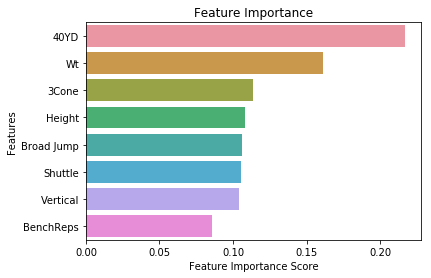

In [48]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance")
plt.show()

In [ ]:
#do random forest again with engineered features 

In [49]:
X = nflwr[['speed_trial','jump_trial','bmi']]
y = nflwr['Round']
y = label_binarize(y, classes=[0,1,2,3,4,5,6,7])
#turn y in to an array, boolean for each round 
n_classes = y.shape[1]

In [50]:
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# classifier
clf=RandomForestClassifier(random_state=0)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [51]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

Draft Round: 0


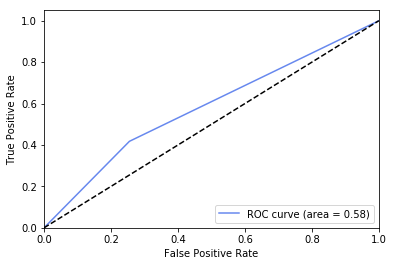

Draft Round: 1


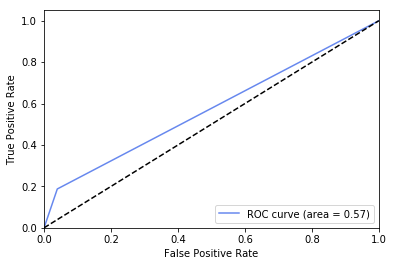

Draft Round: 2


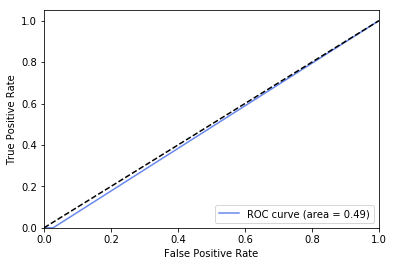

Draft Round: 3


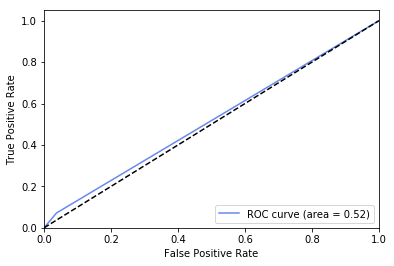

Draft Round: 4


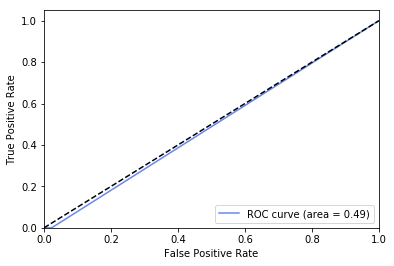

Draft Round: 5


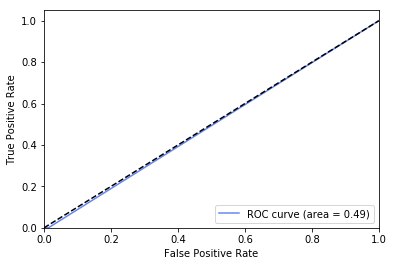

Draft Round: 6


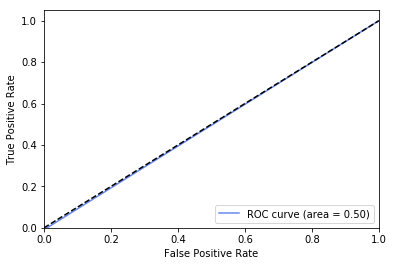

Draft Round: 7


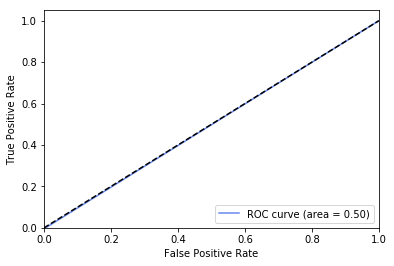

In [52]:
for i in range(n_classes):
    print('Draft Round:',i)
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [53]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

speed_trial    0.380102
bmi            0.360670
jump_trial     0.259228
dtype: float64

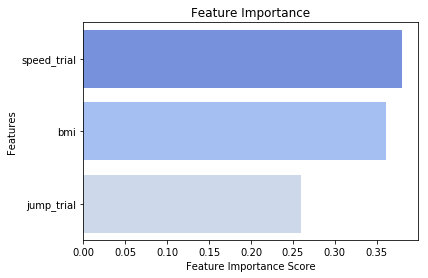

In [54]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance")
plt.show()

<a id="end"></a>
# Conclusion

<a id="find"></a>
## Findings

<a id="next"></a>
## Next Steps

<a id="app"></a>
# Appendex

KNN for all positions: nfl DataFrame

In [ ]:
#matrix (X), response (y)
feature_cols = ['Height', 'Wt', '40YD', 'Vertical', 'BenchReps','Broad Jump','3Cone','Shuttle']
X = nfl[feature_cols]
y = nfl.Round

#break out test and train 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

#try 1 neighbor 
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class)))

#FIND THE BEST K

k_range = list(range(1, 609))
training_error = []
testing_error = []

# Find test accuracy for all values of K between 1 and 100 (inclusive).
for k in k_range:

    # Instantiate the model with the current K value.
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Calculate training error (error = 1 - accuracy).
    y_pred_class = knn.predict(X)
    training_accuracy = metrics.accuracy_score(y, y_pred_class)
    training_error.append(1 - training_accuracy)
    
    # Calculate testing error.
    y_pred_class = knn.predict(X_test)
    testing_accuracy = metrics.accuracy_score(y_test, y_pred_class)
    testing_error.append(1 - testing_accuracy)
    
column_dict = {'K': k_range, 'training error':training_error, 'testing error':testing_error}
df = pd.DataFrame(column_dict).set_index('K').sort_index(ascending=False)
df.head()

df.plot(y='testing error');
plt.xlabel('Value of K for KNN');
plt.ylabel('Error (lower is better)');

df.sort_values('testing error').head()

knn = KNeighborsClassifier(n_neighbors=143)
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class)))

Logistic Regression for NFL dataframe

In [ ]:
lr = LogisticRegression()

X = nfl[['Height','Wt','40YD','Vertical','BenchReps','Broad Jump','3Cone','Shuttle']]
y = nfl['first']

lr.fit(X,y)
pred = lr.predict(X)

X_train, X_test, y_train, y_test = train_test_split(X,y)

lr.fit(X_train,y_train)

y_pred = lr.predict_proba(X_test)

lr.score(X_test, y_test)

Random Forest classifier example 

In [ ]:
X = nflwr[['Height','Wt','40YD','Vertical','BenchReps','Broad Jump','3Cone','Shuttle']]
y = nflwr['Round']
y = label_binarize(y, classes=[0,1,2,3,4,5,6,7])
n_classes = y.shape[1]
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.33, random_state=0)
clf = OneVsRestClassifier(LinearSVC(random_state=0))
y_score = clf.fit(X_train, y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
for i in range(n_classes):
    print('Draft Round:',i)
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    

resources: 
- random forest: https://www.datacamp.com/community/tutorials/random-forests-classifier-python
- roc auc for multiclass: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
- ROC AUC: https://www.dataschool.io/roc-curves-and-auc-explained/
- boosted tree: https://jessesw.com/XG-Boost/ / https://www.kaggle.com/grroverpr/gradient-boosting-simplified/